In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader #Dataset load the data, and DataLoader can split the data into chunks (mini batch)
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score

In [12]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [13]:
PATH = 'gdrive/My Drive/Comp 4211/pa2/'
!ls 'gdrive/My Drive/Comp 4211/pa2/'

 Data	     p1.csv	 'Q8A(3).pt'   test.csv    Yang_Po_Yen_pa2.ipynb
 face.pt    'Q8A(1).pt'   Q8C.pt       train.csv
 index.txt  'Q8A(2).pt'   runs	       valid.csv


In [40]:
train_data_path = os.path.join(PATH, "train.csv")
train = pd.read_csv(train_data_path)
#train.head()
valid_data_path = os.path.join(PATH, "valid.csv")
valid = pd.read_csv(valid_data_path)
#valid.head()
test_data_path = os.path.join(PATH, "test.csv")
test = pd.read_csv(test_data_path)
#test.head()
train.head()

id1  id2  target
0    4    7       1
1    1    4       1
2    3    1       1
3    4    2       1
4    4    1       1

In [15]:
txt_path = os.path.join(PATH, "index.txt")
text = pd.read_csv(txt_path, header = None)
text.head()

0                               1
0  1  Data/Images/001/frontal/01.jpg
1  2  Data/Images/001/frontal/02.jpg
2  3  Data/Images/001/frontal/03.jpg
3  4  Data/Images/001/frontal/04.jpg
4  5  Data/Images/001/frontal/05.jpg

In [16]:
class FaceDataset(Dataset):
    #constructor
    def __init__(self, csv_file, transform = None):
        self.info_df = pd.read_csv(csv_file)                
        self.transform = transform

    def __getitem__(self, idx):
        id1 = self.info_df.iloc[idx, 0]
        id2 = self.info_df.iloc[idx, 1]
        image1 = Image.open(os.path.join(PATH, text.iloc[id1 - 1, 1]))
        image2 = Image.open(os.path.join(PATH, text.iloc[id2 - 1, 1]))
        label = np.array(self.info_df.iloc[idx, 2].astype(np.float32))
        
        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1, image2, label

    def __len__(self):
        return len(self.info_df)

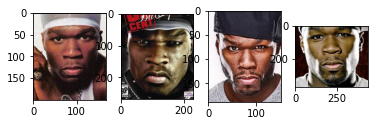

In [17]:
train_dataset = FaceDataset(PATH + "train.csv")
for i in range(len(train_dataset)):
    image1, image2, label = train_dataset[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(image1)
    plt.imshow(image2)
    
    if i == 3:
        plt.show()
        break

In [41]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Grayscale(num_output_channels = 1)]
)

train_trans = FaceDataset((PATH + "train.csv"), transform)
valid_trans = FaceDataset((PATH + "valid.csv"), transform)
test_trans = FaceDataset((PATH + "test.csv"), transform)

bs = 128

train_loader = DataLoader(train_trans, batch_size = bs, shuffle = True, pin_memory = True)
valid_loader = DataLoader(valid_trans, batch_size = bs, shuffle = False, pin_memory = True)
test_loader = DataLoader(test_trans, batch_size = bs, shuffle = False, pin_memory = True)

dataiter = iter(train_loader)
image1, image2, label = dataiter.next()

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1) #32*32*32
        self.norm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1) #32*32*32
        self.norm2 = nn.BatchNorm2d(32)

        self.pool1 = nn.MaxPool2d((2, 2), stride = 2) #32*16*16

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64,  kernel_size = 3, padding = 1) #64*16*16
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128,  kernel_size = 3, padding = 1) #128*16*16
        self.norm4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 3, padding = 1) #256*16*16
        self.norm5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 512,  kernel_size = 3, padding = 1) #512*16*16
        self.norm6 = nn.BatchNorm2d(512)

        self.pool2 = nn.AvgPool2d((16, 16), stride = 1) #512*1*1
        self.flat = nn.Flatten()



    def forward(self, x):
        #  1, 32, 32
        # out_dim = in_dim - kernel_size + 1  
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.pool1(F.relu(self.norm2(self.conv2(x))))
        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))
        x = self.pool2(F.relu(self.norm6(self.conv6(x))))
        x = self.flat(x)
        
        #x = x.view(-1, 512 * 1 * 1)
        #print(x.shape)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
!pip install torchsummaryX
from torchsummaryX import summary

model = Net().cuda()
summary(model, torch.zeros((1, 1, 32, 32)).cuda())

              Kernel Shape      Output Shape    Params    Mult-Adds
Layer                                                              
0_conv1      [1, 32, 3, 3]   [1, 32, 32, 32]     320.0     294.912k
1_norm1               [32]   [1, 32, 32, 32]      64.0         32.0
2_conv2     [32, 32, 3, 3]   [1, 32, 32, 32]    9.248k    9.437184M
3_norm2               [32]   [1, 32, 32, 32]      64.0         32.0
4_pool1                  -   [1, 32, 16, 16]         -            -
5_conv3     [32, 64, 3, 3]   [1, 64, 16, 16]   18.496k    4.718592M
6_norm3               [64]   [1, 64, 16, 16]     128.0         64.0
7_conv4    [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   18.874368M
8_norm4              [128]  [1, 128, 16, 16]     256.0        128.0
9_conv5   [128, 256, 3, 3]  [1, 256, 16, 16]  295.168k   75.497472M
10_norm5             [256]  [1, 256, 16, 16]     512.0        256.0
11_conv6  [256, 512, 3, 3]  [1, 512, 16, 16]  1.18016M  301.989888M
12_norm6             [512]  [1, 512, 16, 16]    

Kernel Shape      Output Shape     Params    Mult-Adds
Layer                                                               
0_conv1      [1, 32, 3, 3]   [1, 32, 32, 32]      320.0     294912.0
1_norm1               [32]   [1, 32, 32, 32]       64.0         32.0
2_conv2     [32, 32, 3, 3]   [1, 32, 32, 32]     9248.0    9437184.0
3_norm2               [32]   [1, 32, 32, 32]       64.0         32.0
4_pool1                  -   [1, 32, 16, 16]        NaN          NaN
5_conv3     [32, 64, 3, 3]   [1, 64, 16, 16]    18496.0    4718592.0
6_norm3               [64]   [1, 64, 16, 16]      128.0         64.0
7_conv4    [64, 128, 3, 3]  [1, 128, 16, 16]    73856.0   18874368.0
8_norm4              [128]  [1, 128, 16, 16]      256.0        128.0
9_conv5   [128, 256, 3, 3]  [1, 256, 16, 16]   295168.0   75497472.0
10_norm5             [256]  [1, 256, 16, 16]      512.0        256.0
11_conv6  [256, 512, 3, 3]  [1, 512, 16, 16]  1180160.0  301989888.0
12_norm6             [512]  [1, 512, 16, 16]     1024.0        512.0
13_pool2                 -    [1, 512, 1, 1]        NaN          NaN
14_flat                  -          [1, 512]        NaN          NaN

In [21]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
        self.drop = nn.Dropout(0.5)


    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [23]:
model = FCNet().cuda()
summary(model, torch.zeros((1, 512)).cuda())

       Kernel Shape Output Shape    Params Mult-Adds
Layer                                               
0_fc1    [512, 512]     [1, 512]  262.656k  262.144k
1_drop            -     [1, 512]         -         -
2_fc2      [512, 1]       [1, 1]     513.0     512.0
-----------------------------------------------------
                        Totals
Total params          263.169k
Trainable params      263.169k
Non-trainable params       0.0
Mult-Adds             262.656k


Kernel Shape Output Shape    Params  Mult-Adds
Layer                                                
0_fc1    [512, 512]     [1, 512]  262656.0   262144.0
1_drop            -     [1, 512]       NaN        NaN
2_fc2      [512, 1]       [1, 1]     513.0      512.0

In [24]:
class SiameseNet(nn.Module):
  def __init__(self, CNN_part, FC_part):
    super(SiameseNet, self).__init__()
    self.cnn = CNN_part
    self.fc = FC_part
    #self.abs = nn.L1Loss(reduction = "none")

  def forward(self, img1, img2):
    img1 = self.cnn(img1)
    img2 = self.cnn(img2)
    abs_value = abs(img1 - img2)
    #print(abs_value.size())
    result = self.fc(abs_value)
    #concat_result = torch.cat((img1, img2), 1)
    #print(concat_result.shape)
    #result = self.fc(concat_result)
    #print(result)
    return result

In [ ]:
full_net = SiameseNet(Net(), FCNet()).cuda()
summary(full_net, torch.zeros((1, 1, 32, 32)).cuda(), torch.zeros((1, 1, 32, 32)).cuda())

                              Kernel Shape      Output Shape    Params  \
Layer                                                                    
0_cnn.Conv2d_conv1           [1, 32, 3, 3]   [1, 32, 32, 32]     320.0   
1_cnn.BatchNorm2d_norm1               [32]   [1, 32, 32, 32]      64.0   
2_cnn.Conv2d_conv2          [32, 32, 3, 3]   [1, 32, 32, 32]    9.248k   
3_cnn.BatchNorm2d_norm2               [32]   [1, 32, 32, 32]      64.0   
4_cnn.MaxPool2d_pool1                    -   [1, 32, 16, 16]         -   
5_cnn.Conv2d_conv3          [32, 64, 3, 3]   [1, 64, 16, 16]   18.496k   
6_cnn.BatchNorm2d_norm3               [64]   [1, 64, 16, 16]     128.0   
7_cnn.Conv2d_conv4         [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   
8_cnn.BatchNorm2d_norm4              [128]  [1, 128, 16, 16]     256.0   
9_cnn.Conv2d_conv5        [128, 256, 3, 3]  [1, 256, 16, 16]  295.168k   
10_cnn.BatchNorm2d_norm5             [256]  [1, 256, 16, 16]     512.0   
11_cnn.Conv2d_conv6       [256, 512, 3

Kernel Shape  ...    Mult-Adds
Layer                                       ...             
0_cnn.Conv2d_conv1           [1, 32, 3, 3]  ...     294912.0
1_cnn.BatchNorm2d_norm1               [32]  ...         32.0
2_cnn.Conv2d_conv2          [32, 32, 3, 3]  ...    9437184.0
3_cnn.BatchNorm2d_norm2               [32]  ...         32.0
4_cnn.MaxPool2d_pool1                    -  ...          NaN
5_cnn.Conv2d_conv3          [32, 64, 3, 3]  ...    4718592.0
6_cnn.BatchNorm2d_norm3               [64]  ...         64.0
7_cnn.Conv2d_conv4         [64, 128, 3, 3]  ...   18874368.0
8_cnn.BatchNorm2d_norm4              [128]  ...        128.0
9_cnn.Conv2d_conv5        [128, 256, 3, 3]  ...   75497472.0
10_cnn.BatchNorm2d_norm5             [256]  ...        256.0
11_cnn.Conv2d_conv6       [256, 512, 3, 3]  ...  301989888.0
12_cnn.BatchNorm2d_norm6             [512]  ...        512.0
13_cnn.AvgPool2d_pool2                   -  ...          NaN
14_cnn.Flatten_flat                      -  ...          NaN
15_cnn.Conv2d_conv1          [1, 32, 3, 3]  ...     294912.0
16_cnn.BatchNorm2d_norm1              [32]  ...         32.0
17_cnn.Conv2d_conv2         [32, 32, 3, 3]  ...    9437184.0
18_cnn.BatchNorm2d_norm2              [32]  ...         32.0
19_cnn.MaxPool2d_pool1                   -  ...          NaN
20_cnn.Conv2d_conv3         [32, 64, 3, 3]  ...    4718592.0
21_cnn.BatchNorm2d_norm3              [64]  ...         64.0
22_cnn.Conv2d_conv4        [64, 128, 3, 3]  ...   18874368.0
23_cnn.BatchNorm2d_norm4             [128]  ...        128.0
24_cnn.Conv2d_conv5       [128, 256, 3, 3]  ...   75497472.0
25_cnn.BatchNorm2d_norm5             [256]  ...        256.0
26_cnn.Conv2d_conv6       [256, 512, 3, 3]  ...  301989888.0
27_cnn.BatchNorm2d_norm6             [512]  ...        512.0
28_cnn.AvgPool2d_pool2                   -  ...          NaN
29_cnn.Flatten_flat                      -  ...          NaN
30_fc.Linear_fc1                [512, 512]  ...     262144.0
31_fc.Dropout_drop                       -  ...          NaN
32_fc.Linear_fc2                  [512, 1]  ...        512.0

[33 rows x 4 columns]

In [25]:
from tqdm.notebook import tqdm
!pip install tqdm

def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path == None:
        return
    save_path = save_path 
    state_dict = {"model_state_dict": model.state_dict(),
                  "optimizer_state_dict": optimizer.state_dict(),
                  "val_loss": val_loss}

    torch.save(state_dict, save_path)
    print(f"Model saved to {save_path}")

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path #f'cifar_net.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
    val_loss = state_dict["val_loss"]
    print(f"Model loaded from {save_path}, with val loss: {val_loss}")
    return val_loss



def TRAIN(net, train_loader, valid_loader, num_epochs, criterion, optimizer, val_loss, device, save_name):
    
    train_loss_record = []
    valid_loss_record = []

  
    if val_loss == None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss = val_loss
        print("Resume training")


    steps = []
    step = 0
    running_loss = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        net.train()
      
        for image1, image2, label in tqdm(train_loader):
     
            image1, image2, label = image1.to(device), image2.to(device), label.to(device)
            label = torch.unsqueeze(label, 1)
            output = net(image1,image2)
            output = output.to(torch.float32)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step = step + 1
            running_loss += loss.item()

            if step % 10 == 0:
              steps.append(step)
    
              with torch.no_grad():
                net.eval()
                val_running_loss = 0
                for image1,image2, label in tqdm(valid_loader):
                  image1, image2, label = image1.to(device), image2.to(device), label.to(device)
                  label = torch.unsqueeze(label, 1)
                  output = net(image1,image2)
                  output = output.to(torch.float32)
                  loss = criterion(output, label)
                  val_running_loss += loss.item()
                valid_loss = val_running_loss / len(valid_loader)
                valid_loss_record.append(valid_loss)
                if valid_loss < best_val_loss:
                  best_val_loss = valid_loss
                  save_checkpoint(save_name, net, optimizer, best_val_loss)
              
              train_loss = running_loss / 10
              train_loss_record.append(train_loss)
              running_loss = 0
              print("Epoch [{}/{}], Step:{}, Train Loss: {:.4f}, Valid Loss: {:.4f}"
                      .format(epoch + 1, num_epochs, step, train_loss, valid_loss))
    print("Finished Training")
    return  steps, train_loss_record, valid_loss_record

In [ ]:
full_net = SiameseNet(Net(), FCNet()).to(device)

num_epochs = 20
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(full_net.parameters())
save_path = os.path.join(PATH, "face.pt")

steps, train_loss_record, valid_loss_record = TRAIN(full_net, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss, device, save_path)


Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [1/20], Step:10, Train Loss: 0.7008, Valid Loss: 0.7019



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [1/20], Step:20, Train Loss: 0.7006, Valid Loss: 0.6901



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [1/20], Step:30, Train Loss: 0.6859, Valid Loss: 0.6891




Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [2/20], Step:40, Train Loss: 0.6853, Valid Loss: 0.6726



Epoch [2/20], Step:50, Train Loss: 0.6905, Valid Loss: 0.6957



Epoch [2/20], Step:60, Train Loss: 0.6877, Valid Loss: 0.6815



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [2/20], Step:70, Train Loss: 0.6673, Valid Loss: 0.6588




Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [3/20], Step:80, Train Loss: 0.6754, Valid Loss: 0.6557



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [3/20], Step:90, Train Loss: 0.6555, Valid Loss: 0.6228



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [3/20], Step:100, Train Loss: 0.6214, Valid Loss: 0.6009



Epoch [3/20], Step:110, Train Loss: 0.6142, Valid Loss: 0.6362




Epoch [4/20], Step:120, Train Loss: 0.6230, Valid Loss: 0.6029



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [4/20], Step:130, Train Loss: 0.5974, Valid Loss: 0.5747



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [4/20], Step:140, Train Loss: 0.6085, Valid Loss: 0.5627



Epoch [4/20], Step:150, Train Loss: 0.5818, Valid Loss: 0.5697




Epoch [5/20], Step:160, Train Loss: 0.6072, Valid Loss: 0.6335



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [5/20], Step:170, Train Loss: 0.5798, Valid Loss: 0.5613



Epoch [5/20], Step:180, Train Loss: 0.5601, Valid Loss: 0.5959



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [5/20], Step:190, Train Loss: 0.5470, Valid Loss: 0.5347




Epoch [6/20], Step:200, Train Loss: 0.5450, Valid Loss: 0.5517



Epoch [6/20], Step:210, Train Loss: 0.5576, Valid Loss: 0.5385



Epoch [6/20], Step:220, Train Loss: 0.5439, Valid Loss: 0.5446



Epoch [6/20], Step:230, Train Loss: 0.5067, Valid Loss: 0.5465




Epoch [7/20], Step:240, Train Loss: 0.5522, Valid Loss: 0.5387



Epoch [7/20], Step:250, Train Loss: 0.5047, Valid Loss: 0.5715



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [7/20], Step:260, Train Loss: 0.5132, Valid Loss: 0.5279



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [7/20], Step:270, Train Loss: 0.4937, Valid Loss: 0.5223




Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [8/20], Step:280, Train Loss: 0.5339, Valid Loss: 0.5183



Epoch [8/20], Step:290, Train Loss: 0.4965, Valid Loss: 0.5223



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [8/20], Step:300, Train Loss: 0.4716, Valid Loss: 0.5073



Epoch [8/20], Step:310, Train Loss: 0.4899, Valid Loss: 0.5338




Epoch [9/20], Step:320, Train Loss: 0.4752, Valid Loss: 0.5304



Epoch [9/20], Step:330, Train Loss: 0.4632, Valid Loss: 0.5579



Epoch [9/20], Step:340, Train Loss: 0.4719, Valid Loss: 0.5231



Epoch [9/20], Step:350, Train Loss: 0.4746, Valid Loss: 0.5331




Epoch [10/20], Step:360, Train Loss: 0.4763, Valid Loss: 0.5180



Epoch [10/20], Step:370, Train Loss: 0.4348, Valid Loss: 0.5548



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [10/20], Step:380, Train Loss: 0.4436, Valid Loss: 0.5064



Epoch [10/20], Step:390, Train Loss: 0.4544, Valid Loss: 0.5222




Epoch [11/20], Step:400, Train Loss: 0.4368, Valid Loss: 0.5957



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [11/20], Step:410, Train Loss: 0.4394, Valid Loss: 0.4954



Epoch [11/20], Step:420, Train Loss: 0.4127, Valid Loss: 0.5142




Epoch [12/20], Step:430, Train Loss: 0.4257, Valid Loss: 0.5095



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [12/20], Step:440, Train Loss: 0.4103, Valid Loss: 0.4877



Epoch [12/20], Step:450, Train Loss: 0.3946, Valid Loss: 0.5178



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [12/20], Step:460, Train Loss: 0.4183, Valid Loss: 0.4873




Epoch [13/20], Step:470, Train Loss: 0.4237, Valid Loss: 0.5007



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [13/20], Step:480, Train Loss: 0.3783, Valid Loss: 0.4741



Epoch [13/20], Step:490, Train Loss: 0.3757, Valid Loss: 0.4859



Epoch [13/20], Step:500, Train Loss: 0.4061, Valid Loss: 0.4826




Epoch [14/20], Step:510, Train Loss: 0.3522, Valid Loss: 0.4901



Model saved to gdrive/My Drive/Comp 4211/pa2/face.pt
Epoch [14/20], Step:520, Train Loss: 0.3722, Valid Loss: 0.4639



Epoch [14/20], Step:530, Train Loss: 0.3736, Valid Loss: 0.4958



Epoch [14/20], Step:540, Train Loss: 0.3607, Valid Loss: 0.4936




Epoch [15/20], Step:550, Train Loss: 0.4001, Valid Loss: 0.4846



Epoch [15/20], Step:560, Train Loss: 0.3603, Valid Loss: 0.4702



Epoch [15/20], Step:570, Train Loss: 0.3439, Valid Loss: 0.4958



Epoch [15/20], Step:580, Train Loss: 0.3466, Valid Loss: 0.4979




Epoch [16/20], Step:590, Train Loss: 0.3367, Valid Loss: 0.5377



Epoch [16/20], Step:600, Train Loss: 0.3632, Valid Loss: 0.4829



Epoch [16/20], Step:610, Train Loss: 0.3280, Valid Loss: 0.4789



Epoch [16/20], Step:620, Train Loss: 0.3175, Valid Loss: 0.4779




Epoch [17/20], Step:630, Train Loss: 0.3266, Valid Loss: 0.5070



Epoch [17/20], Step:640, Train Loss: 0.3189, Valid Loss: 0.4976



Epoch [17/20], Step:650, Train Loss: 0.3298, Valid Loss: 0.4974



Epoch [17/20], Step:660, Train Loss: 0.3351, Valid Loss: 0.5081




Epoch [18/20], Step:670, Train Loss: 0.3089, Valid Loss: 0.5085



Epoch [18/20], Step:680, Train Loss: 0.2963, Valid Loss: 0.4847



Epoch [18/20], Step:690, Train Loss: 0.3184, Valid Loss: 0.5170



Epoch [18/20], Step:700, Train Loss: 0.2741, Valid Loss: 0.4835




Epoch [19/20], Step:710, Train Loss: 0.2688, Valid Loss: 0.5215



Epoch [19/20], Step:720, Train Loss: 0.2848, Valid Loss: 0.5151



Epoch [19/20], Step:730, Train Loss: 0.2593, Valid Loss: 0.5190



Epoch [19/20], Step:740, Train Loss: 0.2844, Valid Loss: 0.5006




Epoch [20/20], Step:750, Train Loss: 0.2743, Valid Loss: 0.5696



Epoch [20/20], Step:760, Train Loss: 0.2684, Valid Loss: 0.5225



Epoch [20/20], Step:770, Train Loss: 0.2695, Valid Loss: 0.5041



Epoch [20/20], Step:780, Train Loss: 0.2606, Valid Loss: 0.5335

Finished Training


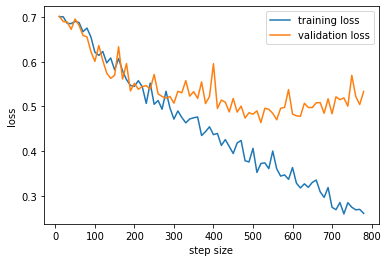

In [ ]:
plt.plot(steps, train_loss_record, label = "training loss")
plt.plot(steps, valid_loss_record, label = "validation loss")
plt.xlabel("step size")
plt.ylabel("loss")
plt.legend()

In [28]:
def find_theta(net, loader):
  net.eval()
  pred_label = []
  true_label = []
  best_accuracy = 0
  best_t = 0
  l = []
  with torch.no_grad():
    for image1, image2, label in loader:
      image1, image2, label = image1.to(device), image2.to(device), label.to(device)
      label = torch.unsqueeze(label, 1)
      output = net(image1, image2)
      pred_label.extend(output.cpu().detach().numpy())
      true_label.extend(label.cpu().detach().numpy())
  for t in tqdm(np.arange(0, 1, 0.001)):
    l = np.array(pred_label)
    l[l > t] = 1
    l[l <= t] = 0
    if (best_accuracy < accuracy_score(true_label, l)):
      best_accuracy = accuracy_score(true_label, l)
      best_t = t

  print(f"Best validation accuracy {best_accuracy} Best threshold {best_t}")
  return best_accuracy, best_t

In [ ]:
full_net = SiameseNet(Net(), FCNet()).to(device)
optimizer = optim.Adam(full_net.parameters())
best_val_loss = load_checkpoint(save_path, full_net, optimizer)
best_accuracy, best_t = find_theta(full_net, valid_loader)

Model loaded from gdrive/My Drive/Comp 4211/pa2/face.pt, with val loss: 0.4638578991095225



Best validation accuracy 0.7957142857142857 Best threshold 0.47700000000000004


In [ ]:
# Q8A(1)
full_net = SiameseNet(Net(), FCNet()).to(device)

num_epochs = 30
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(full_net.parameters(), lr = 0.0005)
save_path = os.path.join(PATH, "Q8A(1).pt")

steps, train_loss_record, valid_loss_record = TRAIN(full_net, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss, device, save_path)


Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [1/30], Step:10, Train Loss: 0.6846, Valid Loss: 0.6886



Epoch [1/30], Step:20, Train Loss: 0.6896, Valid Loss: 0.6949



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [1/30], Step:30, Train Loss: 0.6879, Valid Loss: 0.6866




Epoch [2/30], Step:40, Train Loss: 0.6852, Valid Loss: 0.6894



Epoch [2/30], Step:50, Train Loss: 0.6837, Valid Loss: 0.6884



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [2/30], Step:60, Train Loss: 0.6778, Valid Loss: 0.6831



Epoch [2/30], Step:70, Train Loss: 0.6785, Valid Loss: 0.6888




Epoch [3/30], Step:80, Train Loss: 0.6834, Valid Loss: 0.6890



Epoch [3/30], Step:90, Train Loss: 0.6831, Valid Loss: 0.6954



Epoch [3/30], Step:100, Train Loss: 0.6823, Valid Loss: 0.6882



Epoch [3/30], Step:110, Train Loss: 0.6800, Valid Loss: 0.6833




Epoch [4/30], Step:120, Train Loss: 0.6790, Valid Loss: 0.7000



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [4/30], Step:130, Train Loss: 0.6801, Valid Loss: 0.6814



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [4/30], Step:140, Train Loss: 0.6806, Valid Loss: 0.6805



Epoch [4/30], Step:150, Train Loss: 0.6745, Valid Loss: 0.6903




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [5/30], Step:160, Train Loss: 0.6849, Valid Loss: 0.6796



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [5/30], Step:170, Train Loss: 0.6711, Valid Loss: 0.6691



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [5/30], Step:180, Train Loss: 0.6485, Valid Loss: 0.6545



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [5/30], Step:190, Train Loss: 0.6350, Valid Loss: 0.5994




Epoch [6/30], Step:200, Train Loss: 0.6446, Valid Loss: 0.6535



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [6/30], Step:210, Train Loss: 0.6245, Valid Loss: 0.5750



Epoch [6/30], Step:220, Train Loss: 0.6061, Valid Loss: 0.5972



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [6/30], Step:230, Train Loss: 0.5639, Valid Loss: 0.5614




Epoch [7/30], Step:240, Train Loss: 0.5924, Valid Loss: 0.5747



Epoch [7/30], Step:250, Train Loss: 0.5849, Valid Loss: 0.5927



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [7/30], Step:260, Train Loss: 0.5780, Valid Loss: 0.5444



Epoch [7/30], Step:270, Train Loss: 0.5502, Valid Loss: 0.5726




Epoch [8/30], Step:280, Train Loss: 0.5837, Valid Loss: 0.5636



Epoch [8/30], Step:290, Train Loss: 0.5512, Valid Loss: 0.5548



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [8/30], Step:300, Train Loss: 0.5364, Valid Loss: 0.5239



Epoch [8/30], Step:310, Train Loss: 0.5330, Valid Loss: 0.5346




Epoch [9/30], Step:320, Train Loss: 0.5122, Valid Loss: 0.5846



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [9/30], Step:330, Train Loss: 0.5198, Valid Loss: 0.5237



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [9/30], Step:340, Train Loss: 0.5366, Valid Loss: 0.5208



Epoch [9/30], Step:350, Train Loss: 0.5139, Valid Loss: 0.5360




Epoch [10/30], Step:360, Train Loss: 0.4783, Valid Loss: 0.5264



Epoch [10/30], Step:370, Train Loss: 0.4914, Valid Loss: 0.5482



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [10/30], Step:380, Train Loss: 0.4829, Valid Loss: 0.5042



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [10/30], Step:390, Train Loss: 0.4844, Valid Loss: 0.5011




Epoch [11/30], Step:400, Train Loss: 0.5013, Valid Loss: 0.5150



Epoch [11/30], Step:410, Train Loss: 0.4358, Valid Loss: 0.5151



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [11/30], Step:420, Train Loss: 0.4556, Valid Loss: 0.4906




Epoch [12/30], Step:430, Train Loss: 0.4704, Valid Loss: 0.5226



Epoch [12/30], Step:440, Train Loss: 0.4495, Valid Loss: 0.4931



Epoch [12/30], Step:450, Train Loss: 0.4251, Valid Loss: 0.5340



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [12/30], Step:460, Train Loss: 0.4544, Valid Loss: 0.4823




Epoch [13/30], Step:470, Train Loss: 0.3875, Valid Loss: 0.4915



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [13/30], Step:480, Train Loss: 0.4084, Valid Loss: 0.4789



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [13/30], Step:490, Train Loss: 0.4171, Valid Loss: 0.4742



Epoch [13/30], Step:500, Train Loss: 0.4104, Valid Loss: 0.4778




Epoch [14/30], Step:510, Train Loss: 0.3717, Valid Loss: 0.4781



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [14/30], Step:520, Train Loss: 0.3671, Valid Loss: 0.4626



Epoch [14/30], Step:530, Train Loss: 0.3548, Valid Loss: 0.4873



Epoch [14/30], Step:540, Train Loss: 0.4031, Valid Loss: 0.4857




Epoch [15/30], Step:550, Train Loss: 0.3969, Valid Loss: 0.4758



Epoch [15/30], Step:560, Train Loss: 0.3593, Valid Loss: 0.4872



Epoch [15/30], Step:570, Train Loss: 0.3602, Valid Loss: 0.4631



Epoch [15/30], Step:580, Train Loss: 0.3416, Valid Loss: 0.4817




Epoch [16/30], Step:590, Train Loss: 0.3481, Valid Loss: 0.4751



Epoch [16/30], Step:600, Train Loss: 0.3085, Valid Loss: 0.4799



Epoch [16/30], Step:610, Train Loss: 0.3696, Valid Loss: 0.4675



Epoch [16/30], Step:620, Train Loss: 0.3369, Valid Loss: 0.4640




Epoch [17/30], Step:630, Train Loss: 0.3610, Valid Loss: 0.5012



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [17/30], Step:640, Train Loss: 0.3286, Valid Loss: 0.4597



Epoch [17/30], Step:650, Train Loss: 0.3344, Valid Loss: 0.5312



Epoch [17/30], Step:660, Train Loss: 0.3310, Valid Loss: 0.5009




Epoch [18/30], Step:670, Train Loss: 0.3477, Valid Loss: 0.4668



Epoch [18/30], Step:680, Train Loss: 0.2838, Valid Loss: 0.4616



Epoch [18/30], Step:690, Train Loss: 0.3050, Valid Loss: 0.4789



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt
Epoch [18/30], Step:700, Train Loss: 0.3073, Valid Loss: 0.4526




Epoch [19/30], Step:710, Train Loss: 0.3124, Valid Loss: 0.4950



Epoch [19/30], Step:720, Train Loss: 0.2918, Valid Loss: 0.4660



Epoch [19/30], Step:730, Train Loss: 0.2658, Valid Loss: 0.4808



Epoch [19/30], Step:740, Train Loss: 0.3023, Valid Loss: 0.4695




Epoch [20/30], Step:750, Train Loss: 0.2515, Valid Loss: 0.4993



Epoch [20/30], Step:760, Train Loss: 0.2779, Valid Loss: 0.4784



Epoch [20/30], Step:770, Train Loss: 0.2470, Valid Loss: 0.4715



Epoch [20/30], Step:780, Train Loss: 0.2880, Valid Loss: 0.4909




Epoch [21/30], Step:790, Train Loss: 0.2425, Valid Loss: 0.4753



Epoch [21/30], Step:800, Train Loss: 0.2279, Valid Loss: 0.5046



Epoch [21/30], Step:810, Train Loss: 0.2552, Valid Loss: 0.5280




Epoch [22/30], Step:820, Train Loss: 0.2649, Valid Loss: 0.4998



Epoch [22/30], Step:830, Train Loss: 0.1808, Valid Loss: 0.5545



Epoch [22/30], Step:840, Train Loss: 0.2175, Valid Loss: 0.5168



Epoch [22/30], Step:850, Train Loss: 0.2215, Valid Loss: 0.4714




Epoch [23/30], Step:860, Train Loss: 0.2314, Valid Loss: 0.5092



Epoch [23/30], Step:870, Train Loss: 0.2028, Valid Loss: 0.5377



Epoch [23/30], Step:880, Train Loss: 0.1952, Valid Loss: 0.5201



Epoch [23/30], Step:890, Train Loss: 0.2009, Valid Loss: 0.5246




Epoch [24/30], Step:900, Train Loss: 0.2311, Valid Loss: 0.5199



Epoch [24/30], Step:910, Train Loss: 0.2145, Valid Loss: 0.5032



Epoch [24/30], Step:920, Train Loss: 0.1776, Valid Loss: 0.5387



Epoch [24/30], Step:930, Train Loss: 0.2013, Valid Loss: 0.4885




Epoch [25/30], Step:940, Train Loss: 0.1939, Valid Loss: 0.5556



Epoch [25/30], Step:950, Train Loss: 0.1718, Valid Loss: 0.5084



Epoch [25/30], Step:960, Train Loss: 0.1805, Valid Loss: 0.5296



Epoch [25/30], Step:970, Train Loss: 0.1675, Valid Loss: 0.5612




Epoch [26/30], Step:980, Train Loss: 0.1761, Valid Loss: 0.5331



Epoch [26/30], Step:990, Train Loss: 0.1495, Valid Loss: 0.5746



Epoch [26/30], Step:1000, Train Loss: 0.1740, Valid Loss: 0.5538



Epoch [26/30], Step:1010, Train Loss: 0.1435, Valid Loss: 0.5709




Epoch [27/30], Step:1020, Train Loss: 0.1358, Valid Loss: 0.6037



Epoch [27/30], Step:1030, Train Loss: 0.1425, Valid Loss: 0.5772



Epoch [27/30], Step:1040, Train Loss: 0.1329, Valid Loss: 0.6086



Epoch [27/30], Step:1050, Train Loss: 0.1371, Valid Loss: 0.6263




Epoch [28/30], Step:1060, Train Loss: 0.1424, Valid Loss: 0.6238



Epoch [28/30], Step:1070, Train Loss: 0.1314, Valid Loss: 0.5918



Epoch [28/30], Step:1080, Train Loss: 0.1261, Valid Loss: 0.5602



Epoch [28/30], Step:1090, Train Loss: 0.1006, Valid Loss: 0.5884




Epoch [29/30], Step:1100, Train Loss: 0.0846, Valid Loss: 0.5935



Epoch [29/30], Step:1110, Train Loss: 0.0821, Valid Loss: 0.5705



Epoch [29/30], Step:1120, Train Loss: 0.0771, Valid Loss: 0.5873



Epoch [29/30], Step:1130, Train Loss: 0.0862, Valid Loss: 0.6320




Epoch [30/30], Step:1140, Train Loss: 0.0715, Valid Loss: 0.6336



Epoch [30/30], Step:1150, Train Loss: 0.0610, Valid Loss: 0.6357



Epoch [30/30], Step:1160, Train Loss: 0.0620, Valid Loss: 0.6264



Epoch [30/30], Step:1170, Train Loss: 0.0889, Valid Loss: 0.7019

Finished Training


In [ ]:
# Q8A(1)
full_net = SiameseNet(Net(), FCNet()).to(device)
optimizer = optim.Adam(full_net.parameters(), lr = 0.0005)
best_val_loss = load_checkpoint(save_path, full_net, optimizer)
best_accuracy1, best_t1 = find_theta(full_net, valid_loader)

Model loaded from gdrive/My Drive/Comp 4211/pa2/Q8A(1).pt, with val loss: 0.4526114910840988



Best validation accuracy 0.7985714285714286 Best threshold 0.455


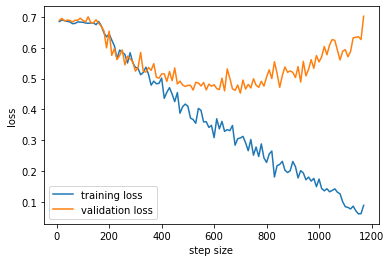

In [ ]:
plt.plot(steps, train_loss_record, label = "training loss")
plt.plot(steps, valid_loss_record, label = "validation loss")
plt.xlabel("step size")
plt.ylabel("loss")
plt.legend()

In [ ]:
# Q8A(2)
full_net = SiameseNet(Net(), FCNet()).to(device)

num_epochs = 50
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(full_net.parameters(), lr = 0.0001)
save_path = os.path.join(PATH, "Q8A(2).pt")

steps, train_loss_record, valid_loss_record = TRAIN(full_net, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss, device, save_path)


Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [1/50], Step:10, Train Loss: 0.6888, Valid Loss: 0.6918



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [1/50], Step:20, Train Loss: 0.6919, Valid Loss: 0.6899



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [1/50], Step:30, Train Loss: 0.6922, Valid Loss: 0.6877




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [2/50], Step:40, Train Loss: 0.6886, Valid Loss: 0.6869



Epoch [2/50], Step:50, Train Loss: 0.6823, Valid Loss: 0.6885



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [2/50], Step:60, Train Loss: 0.6858, Valid Loss: 0.6857



Epoch [2/50], Step:70, Train Loss: 0.6881, Valid Loss: 0.6857




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [3/50], Step:80, Train Loss: 0.6816, Valid Loss: 0.6803



Epoch [3/50], Step:90, Train Loss: 0.6835, Valid Loss: 0.6813



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [3/50], Step:100, Train Loss: 0.6805, Valid Loss: 0.6795



Epoch [3/50], Step:110, Train Loss: 0.6767, Valid Loss: 0.6932




Epoch [4/50], Step:120, Train Loss: 0.6817, Valid Loss: 0.6906



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [4/50], Step:130, Train Loss: 0.6810, Valid Loss: 0.6791



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [4/50], Step:140, Train Loss: 0.6758, Valid Loss: 0.6762



Epoch [4/50], Step:150, Train Loss: 0.6736, Valid Loss: 0.6814




Epoch [5/50], Step:160, Train Loss: 0.6717, Valid Loss: 0.6776



Epoch [5/50], Step:170, Train Loss: 0.6676, Valid Loss: 0.6852



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [5/50], Step:180, Train Loss: 0.6657, Valid Loss: 0.6659



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [5/50], Step:190, Train Loss: 0.6606, Valid Loss: 0.6637




Epoch [6/50], Step:200, Train Loss: 0.6655, Valid Loss: 0.6672



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [6/50], Step:210, Train Loss: 0.6399, Valid Loss: 0.6616



Epoch [6/50], Step:220, Train Loss: 0.6676, Valid Loss: 0.6744



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [6/50], Step:230, Train Loss: 0.6451, Valid Loss: 0.6567




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [7/50], Step:240, Train Loss: 0.6325, Valid Loss: 0.6477



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [7/50], Step:250, Train Loss: 0.6291, Valid Loss: 0.6318



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [7/50], Step:260, Train Loss: 0.5792, Valid Loss: 0.5951



Epoch [7/50], Step:270, Train Loss: 0.5903, Valid Loss: 0.6011




Epoch [8/50], Step:280, Train Loss: 0.5839, Valid Loss: 0.5991



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [8/50], Step:290, Train Loss: 0.5781, Valid Loss: 0.5691



Epoch [8/50], Step:300, Train Loss: 0.5792, Valid Loss: 0.5701



Epoch [8/50], Step:310, Train Loss: 0.5615, Valid Loss: 0.5849




Epoch [9/50], Step:320, Train Loss: 0.5449, Valid Loss: 0.5720



Epoch [9/50], Step:330, Train Loss: 0.5442, Valid Loss: 0.5785



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [9/50], Step:340, Train Loss: 0.5543, Valid Loss: 0.5551



Epoch [9/50], Step:350, Train Loss: 0.5201, Valid Loss: 0.5632




Epoch [10/50], Step:360, Train Loss: 0.5264, Valid Loss: 0.5594



Epoch [10/50], Step:370, Train Loss: 0.5246, Valid Loss: 0.5632



Epoch [10/50], Step:380, Train Loss: 0.5160, Valid Loss: 0.5673



Epoch [10/50], Step:390, Train Loss: 0.4969, Valid Loss: 0.5711




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [11/50], Step:400, Train Loss: 0.4883, Valid Loss: 0.5513



Epoch [11/50], Step:410, Train Loss: 0.4999, Valid Loss: 0.5572



Epoch [11/50], Step:420, Train Loss: 0.4794, Valid Loss: 0.5545




Epoch [12/50], Step:430, Train Loss: 0.4807, Valid Loss: 0.5560



Epoch [12/50], Step:440, Train Loss: 0.4711, Valid Loss: 0.5533



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [12/50], Step:450, Train Loss: 0.4724, Valid Loss: 0.5393



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [12/50], Step:460, Train Loss: 0.4780, Valid Loss: 0.5384




Epoch [13/50], Step:470, Train Loss: 0.4790, Valid Loss: 0.5589



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [13/50], Step:480, Train Loss: 0.4514, Valid Loss: 0.5337



Epoch [13/50], Step:490, Train Loss: 0.4407, Valid Loss: 0.5508



Epoch [13/50], Step:500, Train Loss: 0.4338, Valid Loss: 0.6000




Epoch [14/50], Step:510, Train Loss: 0.4423, Valid Loss: 0.5390



Epoch [14/50], Step:520, Train Loss: 0.4241, Valid Loss: 0.5471



Epoch [14/50], Step:530, Train Loss: 0.4267, Valid Loss: 0.5560



Epoch [14/50], Step:540, Train Loss: 0.4184, Valid Loss: 0.5444




Epoch [15/50], Step:550, Train Loss: 0.4109, Valid Loss: 0.5579



Epoch [15/50], Step:560, Train Loss: 0.3870, Valid Loss: 0.5485



Epoch [15/50], Step:570, Train Loss: 0.3832, Valid Loss: 0.5401



Epoch [15/50], Step:580, Train Loss: 0.3845, Valid Loss: 0.5741




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [16/50], Step:590, Train Loss: 0.3885, Valid Loss: 0.5293



Epoch [16/50], Step:600, Train Loss: 0.3725, Valid Loss: 0.5502



Epoch [16/50], Step:610, Train Loss: 0.3483, Valid Loss: 0.6093



Epoch [16/50], Step:620, Train Loss: 0.3716, Valid Loss: 0.5533




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt
Epoch [17/50], Step:630, Train Loss: 0.3780, Valid Loss: 0.5273



Epoch [17/50], Step:640, Train Loss: 0.3302, Valid Loss: 0.5578



Epoch [17/50], Step:650, Train Loss: 0.3525, Valid Loss: 0.5683



Epoch [17/50], Step:660, Train Loss: 0.3557, Valid Loss: 0.5693




Epoch [18/50], Step:670, Train Loss: 0.3589, Valid Loss: 0.5734



Epoch [18/50], Step:680, Train Loss: 0.3544, Valid Loss: 0.5706



Epoch [18/50], Step:690, Train Loss: 0.3338, Valid Loss: 0.5676



Epoch [18/50], Step:700, Train Loss: 0.3030, Valid Loss: 0.5773




Epoch [19/50], Step:710, Train Loss: 0.3096, Valid Loss: 0.5290



Epoch [19/50], Step:720, Train Loss: 0.3371, Valid Loss: 0.5736



Epoch [19/50], Step:730, Train Loss: 0.2943, Valid Loss: 0.5979



Epoch [19/50], Step:740, Train Loss: 0.3149, Valid Loss: 0.5777




Epoch [20/50], Step:750, Train Loss: 0.2895, Valid Loss: 0.5702



Epoch [20/50], Step:760, Train Loss: 0.2930, Valid Loss: 0.5620



Epoch [20/50], Step:770, Train Loss: 0.2964, Valid Loss: 0.5970



Epoch [20/50], Step:780, Train Loss: 0.2951, Valid Loss: 0.6343




Epoch [21/50], Step:790, Train Loss: 0.3064, Valid Loss: 0.6011



Epoch [21/50], Step:800, Train Loss: 0.2851, Valid Loss: 0.5921



Epoch [21/50], Step:810, Train Loss: 0.2651, Valid Loss: 0.6651




Epoch [22/50], Step:820, Train Loss: 0.3011, Valid Loss: 0.5809



Epoch [22/50], Step:830, Train Loss: 0.2624, Valid Loss: 0.5782



Epoch [22/50], Step:840, Train Loss: 0.2623, Valid Loss: 0.6593



Epoch [22/50], Step:850, Train Loss: 0.2612, Valid Loss: 0.6272




Epoch [23/50], Step:860, Train Loss: 0.2554, Valid Loss: 0.6251



Epoch [23/50], Step:870, Train Loss: 0.2092, Valid Loss: 0.6496



Epoch [23/50], Step:880, Train Loss: 0.2210, Valid Loss: 0.6435



Epoch [23/50], Step:890, Train Loss: 0.2368, Valid Loss: 0.6289




Epoch [24/50], Step:900, Train Loss: 0.2379, Valid Loss: 0.6967



Epoch [24/50], Step:910, Train Loss: 0.2441, Valid Loss: 0.6707



Epoch [24/50], Step:920, Train Loss: 0.2008, Valid Loss: 0.7191



Epoch [24/50], Step:930, Train Loss: 0.2200, Valid Loss: 0.6506




Epoch [25/50], Step:940, Train Loss: 0.2038, Valid Loss: 0.5770



Epoch [25/50], Step:950, Train Loss: 0.1811, Valid Loss: 0.6593



Epoch [25/50], Step:960, Train Loss: 0.2058, Valid Loss: 0.6979



Epoch [25/50], Step:970, Train Loss: 0.1845, Valid Loss: 0.6855




Epoch [26/50], Step:980, Train Loss: 0.1742, Valid Loss: 0.6095



Epoch [26/50], Step:990, Train Loss: 0.1748, Valid Loss: 0.7085



Epoch [26/50], Step:1000, Train Loss: 0.1486, Valid Loss: 0.7212



Epoch [26/50], Step:1010, Train Loss: 0.1921, Valid Loss: 0.6840




Epoch [27/50], Step:1020, Train Loss: 0.1871, Valid Loss: 0.6047



Epoch [27/50], Step:1030, Train Loss: 0.1616, Valid Loss: 0.7278



Epoch [27/50], Step:1040, Train Loss: 0.1365, Valid Loss: 0.7514



Epoch [27/50], Step:1050, Train Loss: 0.1426, Valid Loss: 0.7828




Epoch [28/50], Step:1060, Train Loss: 0.1776, Valid Loss: 0.5787



Epoch [28/50], Step:1070, Train Loss: 0.1649, Valid Loss: 0.7644



Epoch [28/50], Step:1080, Train Loss: 0.1431, Valid Loss: 0.7346



Epoch [28/50], Step:1090, Train Loss: 0.1556, Valid Loss: 0.7247




Epoch [29/50], Step:1100, Train Loss: 0.1643, Valid Loss: 0.8427



Epoch [29/50], Step:1110, Train Loss: 0.2004, Valid Loss: 0.7812



Epoch [29/50], Step:1120, Train Loss: 0.1692, Valid Loss: 0.7455



Epoch [29/50], Step:1130, Train Loss: 0.1521, Valid Loss: 0.7110




Epoch [30/50], Step:1140, Train Loss: 0.1758, Valid Loss: 0.7081



Epoch [30/50], Step:1150, Train Loss: 0.1674, Valid Loss: 0.7525



Epoch [30/50], Step:1160, Train Loss: 0.1078, Valid Loss: 0.8192



Epoch [30/50], Step:1170, Train Loss: 0.1104, Valid Loss: 0.7920




Epoch [31/50], Step:1180, Train Loss: 0.1536, Valid Loss: 0.6340



Epoch [31/50], Step:1190, Train Loss: 0.1127, Valid Loss: 0.7905



Epoch [31/50], Step:1200, Train Loss: 0.1116, Valid Loss: 0.8341




Epoch [32/50], Step:1210, Train Loss: 0.1098, Valid Loss: 0.8848



Epoch [32/50], Step:1220, Train Loss: 0.0967, Valid Loss: 0.8482



Epoch [32/50], Step:1230, Train Loss: 0.1100, Valid Loss: 0.8212



Epoch [32/50], Step:1240, Train Loss: 0.0854, Valid Loss: 0.8321




Epoch [33/50], Step:1250, Train Loss: 0.1130, Valid Loss: 0.7638



Epoch [33/50], Step:1260, Train Loss: 0.1060, Valid Loss: 0.8207



Epoch [33/50], Step:1270, Train Loss: 0.0799, Valid Loss: 0.9130



Epoch [33/50], Step:1280, Train Loss: 0.0873, Valid Loss: 0.8383




Epoch [34/50], Step:1290, Train Loss: 0.0991, Valid Loss: 0.7927



Epoch [34/50], Step:1300, Train Loss: 0.0917, Valid Loss: 0.8935



Epoch [34/50], Step:1310, Train Loss: 0.0783, Valid Loss: 0.8778



Epoch [34/50], Step:1320, Train Loss: 0.0795, Valid Loss: 0.9752




Epoch [35/50], Step:1330, Train Loss: 0.0937, Valid Loss: 0.7326



Epoch [35/50], Step:1340, Train Loss: 0.0796, Valid Loss: 0.8703



Epoch [35/50], Step:1350, Train Loss: 0.0625, Valid Loss: 0.9234



Epoch [35/50], Step:1360, Train Loss: 0.0693, Valid Loss: 0.9640




Epoch [36/50], Step:1370, Train Loss: 0.1054, Valid Loss: 0.7574



Epoch [36/50], Step:1380, Train Loss: 0.0784, Valid Loss: 1.0082



Epoch [36/50], Step:1390, Train Loss: 0.0640, Valid Loss: 0.9380



Epoch [36/50], Step:1400, Train Loss: 0.0583, Valid Loss: 0.9707




Epoch [37/50], Step:1410, Train Loss: 0.0951, Valid Loss: 0.7579



Epoch [37/50], Step:1420, Train Loss: 0.0830, Valid Loss: 0.9586



Epoch [37/50], Step:1430, Train Loss: 0.0627, Valid Loss: 0.9466



Epoch [37/50], Step:1440, Train Loss: 0.0564, Valid Loss: 1.0055




Epoch [38/50], Step:1450, Train Loss: 0.0710, Valid Loss: 0.7629



Epoch [38/50], Step:1460, Train Loss: 0.0526, Valid Loss: 0.9677



Epoch [38/50], Step:1470, Train Loss: 0.0419, Valid Loss: 1.0320



Epoch [38/50], Step:1480, Train Loss: 0.0458, Valid Loss: 0.8932




Epoch [39/50], Step:1490, Train Loss: 0.0768, Valid Loss: 0.7666



Epoch [39/50], Step:1500, Train Loss: 0.0562, Valid Loss: 0.9323



Epoch [39/50], Step:1510, Train Loss: 0.0405, Valid Loss: 0.9530



Epoch [39/50], Step:1520, Train Loss: 0.0395, Valid Loss: 0.9944




Epoch [40/50], Step:1530, Train Loss: 0.0643, Valid Loss: 0.7641



Epoch [40/50], Step:1540, Train Loss: 0.0567, Valid Loss: 1.0271



Epoch [40/50], Step:1550, Train Loss: 0.0725, Valid Loss: 0.9999



Epoch [40/50], Step:1560, Train Loss: 0.0742, Valid Loss: 0.9625




Epoch [41/50], Step:1570, Train Loss: 0.0746, Valid Loss: 0.8416



Epoch [41/50], Step:1580, Train Loss: 0.0612, Valid Loss: 1.0300



Epoch [41/50], Step:1590, Train Loss: 0.0487, Valid Loss: 0.9694




Epoch [42/50], Step:1600, Train Loss: 0.0401, Valid Loss: 1.1016



Epoch [42/50], Step:1610, Train Loss: 0.0320, Valid Loss: 0.9970



Epoch [42/50], Step:1620, Train Loss: 0.0305, Valid Loss: 1.0621



Epoch [42/50], Step:1630, Train Loss: 0.0283, Valid Loss: 1.1675




Epoch [43/50], Step:1640, Train Loss: 0.0443, Valid Loss: 1.0876



Epoch [43/50], Step:1650, Train Loss: 0.0332, Valid Loss: 1.1134



Epoch [43/50], Step:1660, Train Loss: 0.0288, Valid Loss: 1.1464



Epoch [43/50], Step:1670, Train Loss: 0.0427, Valid Loss: 1.0996




Epoch [44/50], Step:1680, Train Loss: 0.0378, Valid Loss: 1.0628



Epoch [44/50], Step:1690, Train Loss: 0.0268, Valid Loss: 1.0913



Epoch [44/50], Step:1700, Train Loss: 0.0215, Valid Loss: 1.1328



Epoch [44/50], Step:1710, Train Loss: 0.0201, Valid Loss: 1.1572




Epoch [45/50], Step:1720, Train Loss: 0.0403, Valid Loss: 1.0734



Epoch [45/50], Step:1730, Train Loss: 0.0521, Valid Loss: 1.2588



Epoch [45/50], Step:1740, Train Loss: 0.0385, Valid Loss: 1.2490



Epoch [45/50], Step:1750, Train Loss: 0.0310, Valid Loss: 1.1880




Epoch [46/50], Step:1760, Train Loss: 0.0482, Valid Loss: 0.9708



Epoch [46/50], Step:1770, Train Loss: 0.0279, Valid Loss: 1.1774



Epoch [46/50], Step:1780, Train Loss: 0.0222, Valid Loss: 1.1062



Epoch [46/50], Step:1790, Train Loss: 0.0264, Valid Loss: 1.0922




Epoch [47/50], Step:1800, Train Loss: 0.0302, Valid Loss: 1.0404



Epoch [47/50], Step:1810, Train Loss: 0.0189, Valid Loss: 1.1764



Epoch [47/50], Step:1820, Train Loss: 0.0198, Valid Loss: 1.1911



Epoch [47/50], Step:1830, Train Loss: 0.0133, Valid Loss: 1.2266




Epoch [48/50], Step:1840, Train Loss: 0.0322, Valid Loss: 0.8776



Epoch [48/50], Step:1850, Train Loss: 0.0230, Valid Loss: 1.1718



Epoch [48/50], Step:1860, Train Loss: 0.0175, Valid Loss: 1.2049



Epoch [48/50], Step:1870, Train Loss: 0.0177, Valid Loss: 1.2310




Epoch [49/50], Step:1880, Train Loss: 0.0307, Valid Loss: 0.9174



Epoch [49/50], Step:1890, Train Loss: 0.0260, Valid Loss: 1.2001



Epoch [49/50], Step:1900, Train Loss: 0.0385, Valid Loss: 1.2407



Epoch [49/50], Step:1910, Train Loss: 0.0428, Valid Loss: 1.2555




Epoch [50/50], Step:1920, Train Loss: 0.0747, Valid Loss: 0.9791



Epoch [50/50], Step:1930, Train Loss: 0.0616, Valid Loss: 1.1464



Epoch [50/50], Step:1940, Train Loss: 0.0350, Valid Loss: 1.2577



Epoch [50/50], Step:1950, Train Loss: 0.0487, Valid Loss: 1.2656

Finished Training


In [ ]:
# Q8A(2)
full_net = SiameseNet(Net(), FCNet()).to(device)
optimizer = optim.Adam(full_net.parameters())
best_val_loss = load_checkpoint(save_path, full_net, optimizer)
best_accuracy2, best_t2 = find_theta(full_net, valid_loader)

Model loaded from gdrive/My Drive/Comp 4211/pa2/Q8A(2).pt, with val loss: 0.5273241450389227



Best validation accuracy 0.74 Best threshold 0.46


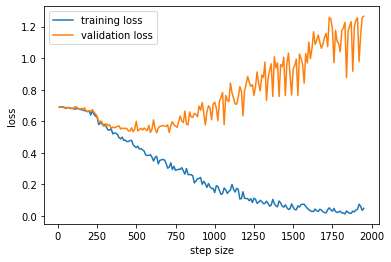

In [ ]:
plt.plot(steps, train_loss_record, label = "training loss")
plt.plot(steps, valid_loss_record, label = "validation loss")
plt.xlabel("step size")
plt.ylabel("loss")
plt.legend()

In [31]:
# Q8A(3)
full_net = SiameseNet(Net(), FCNet()).to(device)

num_epochs = 30
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(full_net.parameters(), lr = 0.001, weight_decay = 0.00001)
save_path = os.path.join(PATH, "Q8A(3).pt")

steps, train_loss_record, valid_loss_record = TRAIN(full_net, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss, device, save_path)


Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [1/30], Step:10, Train Loss: 0.6975, Valid Loss: 0.6921



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [1/30], Step:20, Train Loss: 0.6915, Valid Loss: 0.6848



Epoch [1/30], Step:30, Train Loss: 0.6954, Valid Loss: 0.6867




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [2/30], Step:40, Train Loss: 0.6867, Valid Loss: 0.6837



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [2/30], Step:50, Train Loss: 0.6852, Valid Loss: 0.6815



Epoch [2/30], Step:60, Train Loss: 0.6861, Valid Loss: 0.6824



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [2/30], Step:70, Train Loss: 0.6829, Valid Loss: 0.6795




Epoch [3/30], Step:80, Train Loss: 0.6719, Valid Loss: 0.7060



Epoch [3/30], Step:90, Train Loss: 0.6858, Valid Loss: 0.6892



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [3/30], Step:100, Train Loss: 0.6781, Valid Loss: 0.6722



Epoch [3/30], Step:110, Train Loss: 0.6846, Valid Loss: 0.7090




Epoch [4/30], Step:120, Train Loss: 0.6862, Valid Loss: 0.6898



Epoch [4/30], Step:130, Train Loss: 0.6813, Valid Loss: 0.6745



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [4/30], Step:140, Train Loss: 0.6740, Valid Loss: 0.6650



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [4/30], Step:150, Train Loss: 0.6462, Valid Loss: 0.6521




Epoch [5/30], Step:160, Train Loss: 0.6691, Valid Loss: 0.6691



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [5/30], Step:170, Train Loss: 0.6489, Valid Loss: 0.6366



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [5/30], Step:180, Train Loss: 0.6249, Valid Loss: 0.6023



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [5/30], Step:190, Train Loss: 0.5953, Valid Loss: 0.6018




Epoch [6/30], Step:200, Train Loss: 0.6333, Valid Loss: 0.6617



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [6/30], Step:210, Train Loss: 0.6118, Valid Loss: 0.5714



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [6/30], Step:220, Train Loss: 0.5759, Valid Loss: 0.5636



Epoch [6/30], Step:230, Train Loss: 0.5848, Valid Loss: 0.5906




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [7/30], Step:240, Train Loss: 0.5788, Valid Loss: 0.5595



Epoch [7/30], Step:250, Train Loss: 0.5999, Valid Loss: 0.5746



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [7/30], Step:260, Train Loss: 0.5592, Valid Loss: 0.5397



Epoch [7/30], Step:270, Train Loss: 0.5431, Valid Loss: 0.5495




Epoch [8/30], Step:280, Train Loss: 0.5759, Valid Loss: 0.5453



Epoch [8/30], Step:290, Train Loss: 0.5510, Valid Loss: 0.5586



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [8/30], Step:300, Train Loss: 0.5446, Valid Loss: 0.5189



Epoch [8/30], Step:310, Train Loss: 0.5098, Valid Loss: 0.5544




Epoch [9/30], Step:320, Train Loss: 0.5363, Valid Loss: 0.5418



Epoch [9/30], Step:330, Train Loss: 0.5438, Valid Loss: 0.5413



Epoch [9/30], Step:340, Train Loss: 0.5244, Valid Loss: 0.5306



Epoch [9/30], Step:350, Train Loss: 0.4956, Valid Loss: 0.5353




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [10/30], Step:360, Train Loss: 0.5123, Valid Loss: 0.5166



Epoch [10/30], Step:370, Train Loss: 0.4964, Valid Loss: 0.5315



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [10/30], Step:380, Train Loss: 0.4901, Valid Loss: 0.5127



Epoch [10/30], Step:390, Train Loss: 0.5259, Valid Loss: 0.5714




Epoch [11/30], Step:400, Train Loss: 0.5231, Valid Loss: 0.5737



Epoch [11/30], Step:410, Train Loss: 0.4741, Valid Loss: 0.5564



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [11/30], Step:420, Train Loss: 0.4608, Valid Loss: 0.5042




Epoch [12/30], Step:430, Train Loss: 0.4595, Valid Loss: 0.6214



Epoch [12/30], Step:440, Train Loss: 0.5043, Valid Loss: 0.5355



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [12/30], Step:450, Train Loss: 0.4479, Valid Loss: 0.4995



Epoch [12/30], Step:460, Train Loss: 0.4507, Valid Loss: 0.5214




Epoch [13/30], Step:470, Train Loss: 0.4717, Valid Loss: 0.5448



Epoch [13/30], Step:480, Train Loss: 0.4588, Valid Loss: 0.5306



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [13/30], Step:490, Train Loss: 0.4442, Valid Loss: 0.4972



Epoch [13/30], Step:500, Train Loss: 0.4297, Valid Loss: 0.5027




Epoch [14/30], Step:510, Train Loss: 0.4144, Valid Loss: 0.5193



Epoch [14/30], Step:520, Train Loss: 0.4908, Valid Loss: 0.5331



Epoch [14/30], Step:530, Train Loss: 0.4584, Valid Loss: 0.5175



Epoch [14/30], Step:540, Train Loss: 0.4265, Valid Loss: 0.5045




Epoch [15/30], Step:550, Train Loss: 0.4259, Valid Loss: 0.5114



Epoch [15/30], Step:560, Train Loss: 0.4375, Valid Loss: 0.5265



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [15/30], Step:570, Train Loss: 0.4003, Valid Loss: 0.4891



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [15/30], Step:580, Train Loss: 0.4105, Valid Loss: 0.4833




Epoch [16/30], Step:590, Train Loss: 0.3949, Valid Loss: 0.5109



Epoch [16/30], Step:600, Train Loss: 0.4035, Valid Loss: 0.4986



Epoch [16/30], Step:610, Train Loss: 0.4111, Valid Loss: 0.4868



Epoch [16/30], Step:620, Train Loss: 0.4550, Valid Loss: 0.5068




Epoch [17/30], Step:630, Train Loss: 0.4011, Valid Loss: 0.5221



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [17/30], Step:640, Train Loss: 0.4086, Valid Loss: 0.4828



Epoch [17/30], Step:650, Train Loss: 0.4037, Valid Loss: 0.4943



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [17/30], Step:660, Train Loss: 0.3844, Valid Loss: 0.4805




Epoch [18/30], Step:670, Train Loss: 0.4557, Valid Loss: 0.5314



Epoch [18/30], Step:680, Train Loss: 0.3953, Valid Loss: 0.5211



Epoch [18/30], Step:690, Train Loss: 0.4080, Valid Loss: 0.4847



Epoch [18/30], Step:700, Train Loss: 0.3659, Valid Loss: 0.5101




Epoch [19/30], Step:710, Train Loss: 0.3665, Valid Loss: 0.5109



Epoch [19/30], Step:720, Train Loss: 0.3737, Valid Loss: 0.5014



Epoch [19/30], Step:730, Train Loss: 0.3611, Valid Loss: 0.5163



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [19/30], Step:740, Train Loss: 0.4135, Valid Loss: 0.4783




Epoch [20/30], Step:750, Train Loss: 0.3636, Valid Loss: 0.4973



Epoch [20/30], Step:760, Train Loss: 0.3601, Valid Loss: 0.5058



Epoch [20/30], Step:770, Train Loss: 0.3678, Valid Loss: 0.5202



Epoch [20/30], Step:780, Train Loss: 0.3520, Valid Loss: 0.4844




Epoch [21/30], Step:790, Train Loss: 0.3524, Valid Loss: 0.4955



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [21/30], Step:800, Train Loss: 0.3461, Valid Loss: 0.4753



Epoch [21/30], Step:810, Train Loss: 0.3294, Valid Loss: 0.4773




Epoch [22/30], Step:820, Train Loss: 0.3634, Valid Loss: 0.4918



Epoch [22/30], Step:830, Train Loss: 0.3226, Valid Loss: 0.5295



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [22/30], Step:840, Train Loss: 0.3584, Valid Loss: 0.4744



Epoch [22/30], Step:850, Train Loss: 0.3510, Valid Loss: 0.5057




Epoch [23/30], Step:860, Train Loss: 0.2874, Valid Loss: 0.4769



Epoch [23/30], Step:870, Train Loss: 0.2887, Valid Loss: 0.4839



Epoch [23/30], Step:880, Train Loss: 0.3045, Valid Loss: 0.4984



Epoch [23/30], Step:890, Train Loss: 0.3154, Valid Loss: 0.5194




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt
Epoch [24/30], Step:900, Train Loss: 0.3290, Valid Loss: 0.4651



Epoch [24/30], Step:910, Train Loss: 0.2983, Valid Loss: 0.4874



Epoch [24/30], Step:920, Train Loss: 0.2960, Valid Loss: 0.4659



Epoch [24/30], Step:930, Train Loss: 0.3032, Valid Loss: 0.4756




Epoch [25/30], Step:940, Train Loss: 0.3228, Valid Loss: 0.5457



Epoch [25/30], Step:950, Train Loss: 0.3335, Valid Loss: 0.4964



Epoch [25/30], Step:960, Train Loss: 0.2713, Valid Loss: 0.4988



Epoch [25/30], Step:970, Train Loss: 0.3042, Valid Loss: 0.4781




Epoch [26/30], Step:980, Train Loss: 0.3044, Valid Loss: 0.4859



Epoch [26/30], Step:990, Train Loss: 0.2461, Valid Loss: 0.4956



Epoch [26/30], Step:1000, Train Loss: 0.2333, Valid Loss: 0.5197



Epoch [26/30], Step:1010, Train Loss: 0.2844, Valid Loss: 0.4936




Epoch [27/30], Step:1020, Train Loss: 0.2401, Valid Loss: 0.5078



Epoch [27/30], Step:1030, Train Loss: 0.2457, Valid Loss: 0.5361



Epoch [27/30], Step:1040, Train Loss: 0.2391, Valid Loss: 0.5173



Epoch [27/30], Step:1050, Train Loss: 0.2604, Valid Loss: 0.4997




Epoch [28/30], Step:1060, Train Loss: 0.2269, Valid Loss: 0.5373



Epoch [28/30], Step:1070, Train Loss: 0.2280, Valid Loss: 0.5305



Epoch [28/30], Step:1080, Train Loss: 0.2237, Valid Loss: 0.5190



Epoch [28/30], Step:1090, Train Loss: 0.2276, Valid Loss: 0.5314




Epoch [29/30], Step:1100, Train Loss: 0.2279, Valid Loss: 0.5007



Epoch [29/30], Step:1110, Train Loss: 0.2082, Valid Loss: 0.5208



Epoch [29/30], Step:1120, Train Loss: 0.2498, Valid Loss: 0.5087



Epoch [29/30], Step:1130, Train Loss: 0.2637, Valid Loss: 0.5320




Epoch [30/30], Step:1140, Train Loss: 0.2009, Valid Loss: 0.5494



Epoch [30/30], Step:1150, Train Loss: 0.2134, Valid Loss: 0.5048



Epoch [30/30], Step:1160, Train Loss: 0.2117, Valid Loss: 0.5424



Epoch [30/30], Step:1170, Train Loss: 0.2179, Valid Loss: 0.5212

Finished Training


In [32]:
# Q8A(3)
full_net = SiameseNet(Net(), FCNet()).to(device)
optimizer = optim.Adam(full_net.parameters(), lr = 0.001, weight_decay = 0.00001)
save_path = os.path.join(PATH, "Q8A(3).pt")
best_val_loss = load_checkpoint(save_path, full_net, optimizer)
best_accuracy3, best_t3 = find_theta(full_net, valid_loader)

Model loaded from gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt, with val loss: 0.4650852580865224



Best validation accuracy 0.8028571428571428 Best threshold 0.23900000000000002


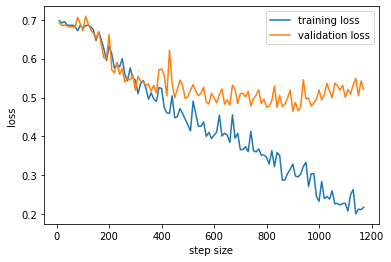

In [33]:
plt.plot(steps, train_loss_record, label = "training loss")
plt.plot(steps, valid_loss_record, label = "validation loss")
plt.xlabel("step size")
plt.ylabel("loss")
plt.legend()

In [48]:
# Q8C
transform_Q8C = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Grayscale(num_output_channels = 1),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10)]
)

train_trans = FaceDataset((PATH + "train.csv"), transform_Q8C)
valid_trans = FaceDataset((PATH + "valid.csv"), transform)
test_trans = FaceDataset((PATH + "test.csv"), transform)

bs = 128

train_loader = DataLoader(train_trans, batch_size = bs, shuffle = True, pin_memory = True)
valid_loader = DataLoader(valid_trans, batch_size = bs, shuffle = False, pin_memory = True)
test_loader = DataLoader(test_trans, batch_size = bs, shuffle = False, pin_memory = True)

dataiter = iter(train_loader)
image1, image2, label = dataiter.next()
#imshow(torchvision.utils.make_grid(image1))

In [49]:
# Q8C
full_net = SiameseNet(Net(), FCNet()).to(device)

num_epochs = 20
best_val_loss = None
criterion = nn.BCELoss()
optimizer = optim.Adam(full_net.parameters())
save_path = os.path.join(PATH, "Q8C.pt")

steps, train_loss_record, valid_loss_record = TRAIN(full_net, train_loader, valid_loader, num_epochs, criterion, optimizer, best_val_loss, device, save_path)


Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [1/20], Step:10, Train Loss: 0.6901, Valid Loss: 0.6891



Epoch [1/20], Step:20, Train Loss: 0.6859, Valid Loss: 0.7118



Epoch [1/20], Step:30, Train Loss: 0.6975, Valid Loss: 0.6908




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [2/20], Step:40, Train Loss: 0.6850, Valid Loss: 0.6837



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [2/20], Step:50, Train Loss: 0.6878, Valid Loss: 0.6820



Epoch [2/20], Step:60, Train Loss: 0.6856, Valid Loss: 0.6921



Epoch [2/20], Step:70, Train Loss: 0.6868, Valid Loss: 0.6942




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [3/20], Step:80, Train Loss: 0.6842, Valid Loss: 0.6806



Epoch [3/20], Step:90, Train Loss: 0.6848, Valid Loss: 0.6947



Epoch [3/20], Step:100, Train Loss: 0.6870, Valid Loss: 0.6904



Epoch [3/20], Step:110, Train Loss: 0.6827, Valid Loss: 0.7013




Epoch [4/20], Step:120, Train Loss: 0.6863, Valid Loss: 0.6816



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [4/20], Step:130, Train Loss: 0.6843, Valid Loss: 0.6757



Epoch [4/20], Step:140, Train Loss: 0.6897, Valid Loss: 0.6949



Epoch [4/20], Step:150, Train Loss: 0.6822, Valid Loss: 0.6830




Epoch [5/20], Step:160, Train Loss: 0.6720, Valid Loss: 0.7303



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [5/20], Step:170, Train Loss: 0.6813, Valid Loss: 0.6430



Epoch [5/20], Step:180, Train Loss: 0.6632, Valid Loss: 0.6799



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [5/20], Step:190, Train Loss: 0.6472, Valid Loss: 0.6350




Epoch [6/20], Step:200, Train Loss: 0.6678, Valid Loss: 0.6514



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [6/20], Step:210, Train Loss: 0.6365, Valid Loss: 0.6076



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [6/20], Step:220, Train Loss: 0.6134, Valid Loss: 0.5785



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [6/20], Step:230, Train Loss: 0.5792, Valid Loss: 0.5572




Epoch [7/20], Step:240, Train Loss: 0.6092, Valid Loss: 0.5851



Epoch [7/20], Step:250, Train Loss: 0.5934, Valid Loss: 0.5679



Epoch [7/20], Step:260, Train Loss: 0.5762, Valid Loss: 0.5618



Epoch [7/20], Step:270, Train Loss: 0.5924, Valid Loss: 0.5894




Epoch [8/20], Step:280, Train Loss: 0.6014, Valid Loss: 0.5612



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [8/20], Step:290, Train Loss: 0.5736, Valid Loss: 0.5476



Epoch [8/20], Step:300, Train Loss: 0.5443, Valid Loss: 0.5814



Epoch [8/20], Step:310, Train Loss: 0.5751, Valid Loss: 0.5765




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [9/20], Step:320, Train Loss: 0.5470, Valid Loss: 0.5412



Epoch [9/20], Step:330, Train Loss: 0.5541, Valid Loss: 0.5460



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [9/20], Step:340, Train Loss: 0.5233, Valid Loss: 0.5279



Epoch [9/20], Step:350, Train Loss: 0.5491, Valid Loss: 0.5377




Epoch [10/20], Step:360, Train Loss: 0.5383, Valid Loss: 0.5295



Epoch [10/20], Step:370, Train Loss: 0.5268, Valid Loss: 0.5306



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [10/20], Step:380, Train Loss: 0.5313, Valid Loss: 0.5236



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [10/20], Step:390, Train Loss: 0.5202, Valid Loss: 0.5189




Epoch [11/20], Step:400, Train Loss: 0.5416, Valid Loss: 0.5471



Epoch [11/20], Step:410, Train Loss: 0.5142, Valid Loss: 0.5236



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [11/20], Step:420, Train Loss: 0.4883, Valid Loss: 0.5101




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [12/20], Step:430, Train Loss: 0.5224, Valid Loss: 0.5052



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [12/20], Step:440, Train Loss: 0.5037, Valid Loss: 0.4989



Epoch [12/20], Step:450, Train Loss: 0.4949, Valid Loss: 0.5177



Epoch [12/20], Step:460, Train Loss: 0.4938, Valid Loss: 0.5032




Epoch [13/20], Step:470, Train Loss: 0.4643, Valid Loss: 0.5009



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [13/20], Step:480, Train Loss: 0.4631, Valid Loss: 0.4987



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [13/20], Step:490, Train Loss: 0.4942, Valid Loss: 0.4982



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [13/20], Step:500, Train Loss: 0.4743, Valid Loss: 0.4901




Epoch [14/20], Step:510, Train Loss: 0.4435, Valid Loss: 0.5070



Epoch [14/20], Step:520, Train Loss: 0.4660, Valid Loss: 0.5079



Epoch [14/20], Step:530, Train Loss: 0.4702, Valid Loss: 0.4963



Epoch [14/20], Step:540, Train Loss: 0.4681, Valid Loss: 0.5013




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [15/20], Step:550, Train Loss: 0.4538, Valid Loss: 0.4885



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [15/20], Step:560, Train Loss: 0.4593, Valid Loss: 0.4790



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [15/20], Step:570, Train Loss: 0.4390, Valid Loss: 0.4699



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [15/20], Step:580, Train Loss: 0.4483, Valid Loss: 0.4595




Epoch [16/20], Step:590, Train Loss: 0.4709, Valid Loss: 0.4700



Epoch [16/20], Step:600, Train Loss: 0.4155, Valid Loss: 0.4661



Epoch [16/20], Step:610, Train Loss: 0.4643, Valid Loss: 0.4736



Epoch [16/20], Step:620, Train Loss: 0.4305, Valid Loss: 0.4728




Epoch [17/20], Step:630, Train Loss: 0.4595, Valid Loss: 0.4823



Epoch [17/20], Step:640, Train Loss: 0.4305, Valid Loss: 0.4691



Epoch [17/20], Step:650, Train Loss: 0.4248, Valid Loss: 0.4652



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [17/20], Step:660, Train Loss: 0.4184, Valid Loss: 0.4473




Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [18/20], Step:670, Train Loss: 0.4118, Valid Loss: 0.4471



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [18/20], Step:680, Train Loss: 0.3932, Valid Loss: 0.4331



Epoch [18/20], Step:690, Train Loss: 0.4129, Valid Loss: 0.4448



Epoch [18/20], Step:700, Train Loss: 0.4456, Valid Loss: 0.4619




Epoch [19/20], Step:710, Train Loss: 0.4254, Valid Loss: 0.4686



Epoch [19/20], Step:720, Train Loss: 0.3958, Valid Loss: 0.4557



Epoch [19/20], Step:730, Train Loss: 0.3846, Valid Loss: 0.4501



Model saved to gdrive/My Drive/Comp 4211/pa2/Q8C.pt
Epoch [19/20], Step:740, Train Loss: 0.4180, Valid Loss: 0.4167




Epoch [20/20], Step:750, Train Loss: 0.4100, Valid Loss: 0.4343



Epoch [20/20], Step:760, Train Loss: 0.3868, Valid Loss: 0.4605



Epoch [20/20], Step:770, Train Loss: 0.3801, Valid Loss: 0.4343



Epoch [20/20], Step:780, Train Loss: 0.3971, Valid Loss: 0.4417

Finished Training


In [50]:
# Q8C
full_net = SiameseNet(Net(), FCNet()).to(device)
optimizer = optim.Adam(full_net.parameters())
best_val_loss = load_checkpoint(save_path, full_net, optimizer)
best_accuracy4, best_t4 = find_theta(full_net, valid_loader)

Model loaded from gdrive/My Drive/Comp 4211/pa2/Q8C.pt, with val loss: 0.41669610639413196



Best validation accuracy 0.8 Best threshold 0.318


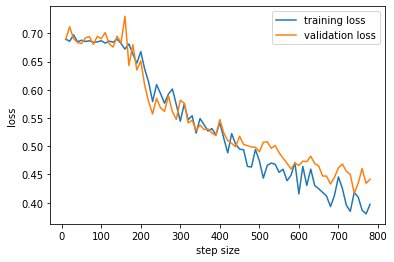

In [51]:
plt.plot(steps, train_loss_record, label = "training loss")
plt.plot(steps, valid_loss_record, label = "validation loss")
plt.xlabel("step size")
plt.ylabel("loss")
plt.legend()

In [42]:
model_best = SiameseNet(Net(), FCNet()).to(device)
optimizer = optim.Adam(model_best.parameters(), lr = 0.001, weight_decay = 0.00001)
save_path = os.path.join(PATH, "Q8A(3).pt")
best_val_loss = load_checkpoint(save_path, model_best, optimizer)

model_best.eval()
pred = []
with torch.no_grad():
    for image1, image2, label in tqdm(test_loader):
      image1, image2 = image1.to(device), image2.to(device)
      test_pred = model_best(image1, image2)
      pred.extend(test_pred.cpu().detach().numpy())
test_label = np.array(pred)
test_label[test_label > best_t3] = 1
test_label[test_label <= best_t3] = 0
for i in range(700):
  test.iloc[i, 2] = test_label[i]

Model loaded from gdrive/My Drive/Comp 4211/pa2/Q8A(3).pt, with val loss: 0.4650852580865224


In [43]:
p1_path = os.path.join(PATH, "p1.csv")
test.to_csv(p1_path, header = True, index = False)

In [44]:
test

id1   id2  target
0    4988  4973     0.0
1    4958  4939     0.0
2    4552  4891     0.0
3    4509  4504     1.0
4    4589  4587     1.0
..    ...   ...     ...
695  4504  4506     1.0
696  4567  4965     0.0
697  4751  4756     1.0
698  4975  4597     0.0
699  4643  4642     1.0

[700 rows x 3 columns]